<a href="https://colab.research.google.com/github/PrswpkWirom/Depression-Detection-FinalProject/blob/main/DD_dataloader%2BVanillaMFFNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import random
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import wave
#from pydub import AudioSegment
from io import BytesIO
from IPython.display import Audio, display
from transformers import RobertaTokenizer, RobertaModel, Wav2Vec2FeatureExtractor
from transformers.models.wavlm import WavLMModel

/home/popsatorn/Desktop/DD_FinalProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
database_dir = '/content/drive/MyDrive/DAIC_WOZ'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-large")
wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-large").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import AutoTokenizer, AutoModel
model_name = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name)
text_model = text_model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Attempt 1

In [ ]:
def get_sentence_level_text_embedding(sentence, tokenizer, text_model):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
    sentence_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
    return sentence_embedding.squeeze(0)

def get_audio_embedding(audio_segment, feature_extractor, wavlm_model):
    audio_data = np.array(audio_segment.get_array_of_samples()).astype(np.int16)
    audio_data_tensor = torch.tensor(audio_data, dtype=torch.float32).to(device)

    inputs = feature_extractor(
        audio_data_tensor,
        sampling_rate=audio_segment.frame_rate,
        return_tensors="pt",
        padding=True
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = wavlm_model(**inputs)

    # last_hidden_state: (1, time_steps, embedding_dim)
    audio_embeddings = outputs.last_hidden_state.squeeze(0)
    # Average pooling over time
    audio_embedding_vector = audio_embeddings.mean(dim=0)
    return audio_embedding_vector


In [ ]:
def load_label_dict(label_csv_path):
    """
    Loads a CSV file that contains columns: "ID" and "PHQ8_Binary".
    Returns a dictionary mapping the string ID (e.g., "315") to the binary label (0 or 1).
    """
    df = pd.read_csv(label_csv_path)
    label_dict = {}
    for _, row in df.iterrows():
        base_id = str(row["Participant_ID"])  # Ensure it's a string for indexing
        label = int(row["PHQ8_Binary"])
        label_dict[base_id] = label
    return label_dict

In [ ]:
class DAICDataset(Dataset):
    def __init__(self, root_dir, label_csv_path, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir='embeddings'):
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.text_model = text_model
        self.feature_extractor = feature_extractor
        self.wavlm_model = wavlm_model
        self.device = device
        self.embeddings_dir = embeddings_dir

        # Load labels as before
        self.label_dict = load_label_dict(label_csv_path)

        self.session_ids = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.data = []
        self._prepare_data()

    def _prepare_data(self):
        # Ensure the embeddings directory for this split exists
        if not os.path.exists(self.embeddings_dir):
            os.makedirs(self.embeddings_dir)

        split_name = os.path.basename(self.root_dir)  # e.g., 'train', 'validate', 'test'
        split_embeddings_dir = os.path.join(self.embeddings_dir, split_name)
        if not os.path.exists(split_embeddings_dir):
            os.makedirs(split_embeddings_dir)

        for session_id in self.session_ids:
            base_id = session_id.split('_')[0]
            session_path = os.path.join(self.root_dir, session_id)
            embed_file_path = os.path.join(split_embeddings_dir, f"{session_id}.pt")

            if os.path.exists(embed_file_path):
                # Load precomputed embeddings
                saved_data = torch.load(embed_file_path)
                text_sequence = saved_data['text_sequence']
                audio_sequence = saved_data['audio_sequence']
                label = saved_data['label']
                self.data.append((text_sequence, audio_sequence, label))
                continue

            # If embeddings file doesn't exist, proceed with computation
            transcript_file, audio_file = self._find_files(session_path)
            if transcript_file is None or audio_file is None:
                print(f"Missing transcript or audio for {session_id}, skipping.")
                continue

            filtered_df = self._load_and_filter_transcript(transcript_file)
            if filtered_df is None:
                continue

            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                continue
            full_audio = AudioSegment.from_wav(audio_file)

            aligned_data = []
            for _, row in filtered_df.iterrows():
                try:
                    start_time = float(row["start_time"])
                    stop_time = float(row["stop_time"])
                    sentence = row["value"]
                    start_ms = int(start_time * 1000)
                    stop_ms = int(stop_time * 1000)
                    audio_segment = full_audio[start_ms:stop_ms]

                    aligned_data.append({
                        "start_time": start_time,
                        "stop_time": stop_time,
                        "sentence": sentence,
                        "audio_segment": audio_segment
                    })
                except ValueError:
                    continue

            if len(aligned_data) == 0:
                continue

            # Compute embeddings
            text_embeddings = []
            audio_embeddings = []
            for entry in aligned_data:
                text_emb = get_sentence_level_text_embedding(entry["sentence"], self.tokenizer, self.text_model)
                audio_emb = get_audio_embedding(entry["audio_segment"], self.feature_extractor, self.wavlm_model)
                text_embeddings.append(text_emb)
                audio_embeddings.append(audio_emb)
                #print(f"Succesfully generate embedding of {entry}")

            if len(text_embeddings) == 0:
                continue

            text_sequence = torch.stack(text_embeddings, dim=0)
            audio_sequence = torch.stack(audio_embeddings, dim=0)

            if base_id not in self.label_dict:
                print(f"No label for {base_id}, defaulting to 0.")
                label = 0
            else:
                label = self.label_dict[base_id]

            # Save embeddings to disk
            torch.save({
                'text_sequence': text_sequence,
                'audio_sequence': audio_sequence,
                'label': label
            }, embed_file_path)

            # Add to dataset memory
            self.data.append((text_sequence, audio_sequence, label))

    def _find_files(self, session_path):
        transcript_file = None
        audio_file = None
        for fn in os.listdir(session_path):
            if fn.endswith("_TRANSCRIPT.csv"):
                transcript_file = os.path.join(session_path, fn)
            if fn.endswith("_AUDIO.wav"):
                audio_file = os.path.join(session_path, fn)
        return transcript_file, audio_file

    def _load_and_filter_transcript(self, transcript_file):
        df = pd.read_csv(transcript_file, usecols=[0], header=None)
        df_split = df[0].str.split('\t', expand=True)
        if df_split.shape[1] < 4:
            print(f"Transcript file {transcript_file} has unexpected format.")
            return None
        df_split.columns = ["start_time", "stop_time", "speaker", "value"]
        filtered_df = df_split[df_split["speaker"] != "Ellie"]
        return filtered_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
def collate_fn(batch):
    text_seqs = [item[0] for item in batch]
    audio_seqs = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    # Pad sequences along time dimension
    max_len_text = max(seq.size(0) for seq in text_seqs)
    max_len_audio = max(seq.size(0) for seq in audio_seqs)

    padded_text = []
    for seq in text_seqs:
        if seq.size(0) < max_len_text:
            diff = max_len_text - seq.size(0)
            pad_tensor = torch.zeros(diff, seq.size(1))
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_text.append(seq.unsqueeze(0))
    padded_text = torch.cat(padded_text, dim=0)  # [batch_size, max_len_text, D]

    padded_audio = []
    for seq in audio_seqs:
        if seq.size(0) < max_len_audio:
            diff = max_len_audio - seq.size(0)
            pad_tensor = torch.zeros(diff, seq.size(1))
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_audio.append(seq.unsqueeze(0))
    padded_audio = torch.cat(padded_audio, dim=0) # [batch_size, max_len_audio, D]

    labels = torch.tensor(labels, dtype=torch.long)

    return padded_text, padded_audio, labels


In [ ]:
train_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/DD_final_project/csv/train_set.csv')
val_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/DD_final_project/csv/validation_set.csv')
test_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/DD_final_project/csv/full_test_split.csv')

train_dir = os.path.join(database_dir, 'train')
val_dir = os.path.join(database_dir, 'validate')
test_dir = os.path.join(database_dir, 'test')

In [ ]:
train_dataset = DAICDataset(train_dir, train_label_csv, tokenizer, text_model, feature_extractor, wavlm_model, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


No label for 344, defaulting to 0.


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv(train_label_csv)

In [ ]:
df

In [ ]:
df.info()

# Attempt2

In [ ]:
def get_sentence_level_text_embedding(sentence, tokenizer, text_model):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
    sentence_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
    return sentence_embedding.squeeze(0)

def get_audio_embedding(audio_segment, feature_extractor, wavlm_model):
    audio_data = np.array(audio_segment.get_array_of_samples()).astype(np.int16)
    audio_data_tensor = torch.tensor(audio_data, dtype=torch.float32).to(device)

    inputs = feature_extractor(
        audio_data_tensor,
        sampling_rate=audio_segment.frame_rate,
        return_tensors="pt",
        padding=True
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = wavlm_model(**inputs)

    # last_hidden_state: (1, time_steps, embedding_dim)
    audio_embeddings = outputs.last_hidden_state.squeeze(0)
    # Average pooling over time
    audio_embedding_vector = audio_embeddings.mean(dim=0)
    return audio_embedding_vector

def load_label_dict(label_csv_path):
    """
    Loads a CSV file that contains at least these columns: "Participant_ID", "PHQ8_Binary".
    Converts Participant_ID to an integer, then to a string to match how we handle directory-based IDs.
    """
    df = pd.read_csv(label_csv_path)
    label_dict = {}
    for _, row in df.iterrows():
        # Convert participant_id to integer, then to string for consistency
        base_id_str = str(int(row["Participant_ID"]))  # Ensures "315.0" becomes "315"
        label = int(row["PHQ8_Binary"])
        label_dict[base_id_str] = label
        print(f"Loaded label for {base_id_str}: {label}")
    return label_dict

class DAICDataset(Dataset):
    def __init__(self, root_dir, label_csv_path, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=None):
        """
        root_dir: path to the split directory (train, validate, or test) containing session folders.
        label_csv_path: path to the CSV file containing Participant_ID and PHQ8_Binary columns.
        embeddings_dir: optional directory to save/load precomputed embeddings.
        """
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.text_model = text_model
        self.feature_extractor = feature_extractor
        self.wavlm_model = wavlm_model
        self.device = device
        self.embeddings_dir = embeddings_dir

        # Load the label dictionary
        self.label_dict = load_label_dict(label_csv_path)

        self.session_ids = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.data = []
        self._prepare_data()

    def _prepare_data(self):
        # If embeddings_dir is provided, create split-specific dir
        split_name = os.path.basename(self.root_dir)  # 'train', 'validate', 'test'
        if self.embeddings_dir is not None:
            split_embeddings_dir = os.path.join(self.embeddings_dir, split_name)
            os.makedirs(split_embeddings_dir, exist_ok=True)
        else:
            split_embeddings_dir = None

        for session_id in self.session_ids:
            base_id_str = session_id.split('_')[0]  # e.g. "315" from "315_P"
            print(base_id_str)
            # Check if we have precomputed embeddings
            embed_file_path = None
            if split_embeddings_dir is not None:
                embed_file_path = os.path.join(split_embeddings_dir, f"{session_id}.pt")
                if os.path.exists(embed_file_path):
                    # Load precomputed embeddings
                    saved_data = torch.load(embed_file_path)
                    text_sequence = saved_data['text_sequence']
                    audio_sequence = saved_data['audio_sequence']
                    label = saved_data['label']
                    self.data.append((text_sequence, audio_sequence, label))
                    continue

            # If we don't have precomputed embeddings or embeddings_dir not used, process data
            transcript_file, audio_file = self._find_files(session_id)
            if transcript_file is None or audio_file is None:
                print(f"Transcript or audio missing for {session_id}, skipping.")
                continue

            filtered_df = self._load_and_filter_transcript(transcript_file)
            if filtered_df is None or len(filtered_df) == 0:
                # No valid transcripts after filtering Ellie
                continue

            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                continue

            full_audio = AudioSegment.from_wav(audio_file)

            aligned_data = []
            for _, row in filtered_df.iterrows():
                try:
                    start_time = float(row["start_time"])
                    stop_time = float(row["stop_time"])
                    sentence = row["value"]
                    start_ms = int(start_time * 1000)
                    stop_ms = int(stop_time * 1000)
                    audio_segment = full_audio[start_ms:stop_ms]

                    aligned_data.append({
                        "start_time": start_time,
                        "stop_time": stop_time,
                        "sentence": sentence,
                        "audio_segment": audio_segment
                    })
                except ValueError:
                    continue

            if len(aligned_data) == 0:
                # No valid sentences
                continue
            min_duration = 0.1  # minimum duration in seconds

            if (len(audio_segment) / 1000.0) < min_duration:
            # Skip this segment
                continue


            text_embeddings = []
            audio_embeddings = []
            for entry in aligned_data:
                text_emb = get_sentence_level_text_embedding(entry["sentence"], self.tokenizer, self.text_model)
                audio_emb = get_audio_embedding(entry["audio_segment"], self.feature_extractor, self.wavlm_model)
                text_embeddings.append(text_emb)
                audio_embeddings.append(audio_emb)

            if len(text_embeddings) == 0:
                continue

            # Stack embeddings: [num_sentences, embedding_dim]
            text_sequence = torch.stack(text_embeddings, dim=0)
            audio_sequence = torch.stack(audio_embeddings, dim=0)

            # Move them to CPU before storing in self.data
            text_sequence = text_sequence.cpu()
            audio_sequence = audio_sequence.cpu()

            if base_id_str not in self.label_dict:
                print(f"No label found for {base_id_str}")
                label = 0
            else:
                label = self.label_dict[base_id_str]
                print(f"{base_id_str}: {label}")

            # Save embeddings if path is given
            if embed_file_path is not None:
                torch.save({
                    'text_sequence': text_sequence,
                    'audio_sequence': audio_sequence,
                    'label': label
                }, embed_file_path)

            self.data.append((text_sequence, audio_sequence, label))


    def _find_files(self, session_id):
        session_path = os.path.join(self.root_dir, session_id)
        transcript_file = None
        audio_file = None
        for fn in os.listdir(session_path):
            if fn.endswith("_TRANSCRIPT.csv"):
                transcript_file = os.path.join(session_path, fn)
            if fn.endswith("_AUDIO.wav"):
                audio_file = os.path.join(session_path, fn)
        return transcript_file, audio_file

    def _load_and_filter_transcript(self, transcript_file):
        df = pd.read_csv(transcript_file, usecols=[0], header=None)
        df_split = df[0].str.split('\t', expand=True)
        if df_split.shape[1] < 4:
            print(f"Transcript file {transcript_file} has unexpected format.")
            return None
        df_split.columns = ["start_time", "stop_time", "speaker", "value"]
        filtered_df = df_split[df_split["speaker"] != "Ellie"]
        return filtered_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
def collate_fn(batch):
    text_seqs = [item[0] for item in batch]  # CPU tensors
    audio_seqs = [item[1] for item in batch] # CPU tensors
    labels = [item[2] for item in batch]

    max_len_text = max(seq.size(0) for seq in text_seqs)
    max_len_audio = max(seq.size(0) for seq in audio_seqs)

    padded_text = []
    for seq in text_seqs:
        if seq.size(0) < max_len_text:
            diff = max_len_text - seq.size(0)
            pad_tensor = torch.zeros(diff, seq.size(1))  # should be CPU
            # Debug prints for text sequence
            #print("Text seq device before cat:", seq.device)
            #print("Text pad_tensor device before cat:", pad_tensor.device)
            seq = torch.cat([seq, pad_tensor], dim=0)  # Both seq and pad_tensor should be on CPU
            #print("Text seq device after cat:", seq.device)
        padded_text.append(seq.unsqueeze(0))
    padded_text = torch.cat(padded_text, dim=0)  # [batch_size, max_len_text, D]

    padded_audio = []
    for seq in audio_seqs:
        if seq.size(0) < max_len_audio:
            diff = max_len_audio - seq.size(0)
            pad_tensor = torch.zeros(diff, seq.size(1))  # should be CPU
            # Debug prints for audio sequence
            #print("Audio seq device before cat:", seq.device)
            #print("Audio pad_tensor device before cat:", pad_tensor.device)
            seq = torch.cat([seq, pad_tensor], dim=0)  # Both seq and pad_tensor should be on CPU
            #print("Audio seq device after cat:", seq.device)
        padded_audio.append(seq.unsqueeze(0))
    padded_audio = torch.cat(padded_audio, dim=0) # [batch_size, max_len_audio, D]

    labels = torch.tensor(labels, dtype=torch.long)  # CPU

    #print("Final shapes:", padded_text.shape, padded_audio.shape, labels.shape)
    #print("Final devices:", padded_text.device, padded_audio.device, labels.device)

    return padded_text, padded_audio, labels


In [ ]:
train_label_csv = "/content/drive/MyDrive/pkl/train_set.csv"
val_label_csv = "/content/drive/MyDrive/pkl/validation_set.csv"
test_label_csv = "/content/drive/MyDrive/pkl/full_test_split.csv"

train_dir = os.path.join(database_dir, 'train')
val_dir = os.path.join(database_dir, 'validate')
test_dir = os.path.join(database_dir, 'test')


# Generate .pt files to drive

In [6]:
train_embedding_dir = '/content/drive/MyDrive/Embeddings_sub/Embeddings_small/train'
test_embedding_dir = '/content/drive/MyDrive/Embeddings_sub/Embeddings_small/test'
val_embedding_dir = '/content/drive/MyDrive/Embeddings_sub/Embeddings_small/validate'
embeddings_dir = '/content/drive/MyDrive/Embeddings_sub/Embeddings_small'

In [7]:
train_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/pkl/train_set.csv')
val_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/pkl/validation_set.csv')
test_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/pkl/full_test_split.csv')

train_dir = os.path.join(database_dir, 'train')
val_dir = os.path.join(database_dir, 'validate')
test_dir = os.path.join(database_dir, 'test')

NameError: name 'database_dir' is not defined

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pydub import AudioSegment

def get_sentence_level_text_embedding(sentence, tokenizer, text_model, device):
    # Generate attention_mask for text embeddings
    inputs = tokenizer(
        sentence,
        return_tensors="pt",
        padding=True,
        truncation=True,
        return_attention_mask=True
    ).to(device)

    with torch.no_grad():
        outputs = text_model(**inputs)
    # Take [CLS] token embedding
    sentence_embedding = outputs.last_hidden_state[:, 0, :]
    return sentence_embedding.squeeze(0)

def get_audio_embedding(audio_segment, feature_extractor, wavlm_model, device):
    audio_data = np.array(audio_segment.get_array_of_samples()).astype(np.int16)
    audio_data_tensor = torch.tensor(audio_data, dtype=torch.float32).to(device)

    # Generate attention_mask for audio embeddings
    inputs = feature_extractor(
        audio_data_tensor,
        sampling_rate=audio_segment.frame_rate,
        return_tensors="pt",
        padding=True,
        return_attention_mask=True
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = wavlm_model(**inputs)

    # outputs.last_hidden_state: (1, time_steps, embedding_dim)
    audio_embeddings = outputs.last_hidden_state.squeeze(0)
    # Average pooling over time
    audio_embedding_vector = audio_embeddings.mean(dim=0)
    return audio_embedding_vector

def load_label_dict(label_csv_path):
    """
    Loads a CSV file that contains at least these columns: "Participant_ID", "PHQ8_Binary".
    Converts Participant_ID to an integer, then to a string to match how we handle directory-based IDs.
    """
    df = pd.read_csv(label_csv_path)
    label_dict = {}
    for _, row in df.iterrows():
        base_id_str = str(int(row["Participant_ID"]))  # Ensures "315.0" becomes "315"
        label = int(row["PHQ8_Binary"])
        label_dict[base_id_str] = label
        print(f"Loaded label for {base_id_str}: {label}")
    return label_dict

class DAICDataset(Dataset):
    def __init__(self, root_dir, label_csv_path, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=None):
        """
        root_dir: path to the split directory (train, validate, or test) containing session folders.
        label_csv_path: path to the CSV file containing Participant_ID and PHQ8_Binary columns.
        embeddings_dir: optional directory to save/load precomputed embeddings.
        """
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.text_model = text_model
        self.feature_extractor = feature_extractor
        self.wavlm_model = wavlm_model
        self.device = device
        self.embeddings_dir = embeddings_dir

        # Load the label dictionary
        self.label_dict = load_label_dict(label_csv_path)

        self.session_ids = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.data = []
        self._prepare_data()

    def _prepare_data(self):
        # If embeddings_dir is provided, create split-specific dir
        split_name = os.path.basename(self.root_dir)  # 'train', 'validate', 'test'
        if self.embeddings_dir is not None:
            split_embeddings_dir = os.path.join(self.embeddings_dir, split_name)
            os.makedirs(split_embeddings_dir, exist_ok=True)
        else:
            split_embeddings_dir = None

        for session_id in self.session_ids:
            base_id_str = session_id.split('_')[0]  # e.g. "315" from "315_P"
            print(base_id_str)
            # Check if we have precomputed embeddings
            embed_file_path = None
            if split_embeddings_dir is not None:
                embed_file_path = os.path.join(split_embeddings_dir, f"{session_id}.pt")
                if os.path.exists(embed_file_path):
                    # Load precomputed embeddings
                    saved_data = torch.load(embed_file_path)
                    text_sequence = saved_data['text_sequence']
                    audio_sequence = saved_data['audio_sequence']
                    label = saved_data['label']
                    self.data.append((text_sequence, audio_sequence, label))
                    continue

            # If we don't have precomputed embeddings or embeddings_dir not used, process data
            transcript_file, audio_file = self._find_files(session_id)
            if transcript_file is None or audio_file is None:
                print(f"Transcript or audio missing for {session_id}, skipping.")
                continue

            filtered_df = self._load_and_filter_transcript(transcript_file)
            if filtered_df is None or len(filtered_df) == 0:
                # No valid transcripts after filtering Ellie
                continue

            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                continue

            full_audio = AudioSegment.from_wav(audio_file)

            aligned_data = []
            for _, row in filtered_df.iterrows():
                try:
                    start_time = float(row["start_time"])
                    stop_time = float(row["stop_time"])
                    sentence = row["value"]
                    start_ms = int(start_time * 1000)
                    stop_ms = int(stop_time * 1000)
                    audio_segment = full_audio[start_ms:stop_ms]

                    # Minimum duration
                    min_duration = 0.1  # seconds
                    if (len(audio_segment) / 1000.0) < min_duration:
                        continue

                    aligned_data.append({
                        "start_time": start_time,
                        "stop_time": stop_time,
                        "sentence": sentence,
                        "audio_segment": audio_segment
                    })
                except ValueError:
                    continue

            if len(aligned_data) == 0:
                # No valid sentences
                continue

            text_embeddings = []
            audio_embeddings = []
            for entry in aligned_data:
                text_emb = get_sentence_level_text_embedding(entry["sentence"], self.tokenizer, self.text_model, self.device)
                audio_emb = get_audio_embedding(entry["audio_segment"], self.feature_extractor, self.wavlm_model, self.device)
                text_embeddings.append(text_emb)
                audio_embeddings.append(audio_emb)

            if len(text_embeddings) == 0:
                continue

            # Stack embeddings: [num_sentences, embedding_dim]
            text_sequence = torch.stack(text_embeddings, dim=0)
            audio_sequence = torch.stack(audio_embeddings, dim=0)

            # Move them to CPU before storing in self.data
            text_sequence = text_sequence.cpu()
            audio_sequence = audio_sequence.cpu()

            if base_id_str not in self.label_dict:
                print(f"No label found for {base_id_str}")
                label = 0
            else:
                label = self.label_dict[base_id_str]
                print(f"{base_id_str}: {label}")

            # Save embeddings if path is given
            if embed_file_path is not None:
                torch.save({
                    'text_sequence': text_sequence,
                    'audio_sequence': audio_sequence,
                    'label': label
                }, embed_file_path)

            self.data.append((text_sequence, audio_sequence, label))

    def _find_files(self, session_id):
        session_path = os.path.join(self.root_dir, session_id)
        transcript_file = None
        audio_file = None
        for fn in os.listdir(session_path):
            if fn.endswith("_TRANSCRIPT.csv"):
                transcript_file = os.path.join(session_path, fn)
            if fn.endswith("_AUDIO.wav"):
                audio_file = os.path.join(session_path, fn)
        return transcript_file, audio_file

    def _load_and_filter_transcript(self, transcript_file):
        df = pd.read_csv(transcript_file, usecols=[0], header=None)
        df_split = df[0].str.split('\t', expand=True)
        if df_split.shape[1] < 4:
            print(f"Transcript file {transcript_file} has unexpected format.")
            return None
        df_split.columns = ["start_time", "stop_time", "speaker", "value"]
        filtered_df = df_split[df_split["speaker"] != "Ellie"]
        return filtered_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    text_seqs = [item[0] for item in batch]  # CPU tensors [seq_len, text_dim]
    audio_seqs = [item[1] for item in batch] # CPU tensors [seq_len, audio_dim]
    labels = [item[2] for item in batch]

    # Compute max lengths for padding
    max_len_text = max(seq.size(0) for seq in text_seqs)
    max_len_audio = max(seq.size(0) for seq in audio_seqs)

    # Initialize masks
    text_mask = torch.zeros(len(text_seqs), max_len_text, dtype=torch.long)
    audio_mask = torch.zeros(len(audio_seqs), max_len_audio, dtype=torch.long)

    padded_text = []
    for i, seq in enumerate(text_seqs):
        original_len = seq.size(0)
        if original_len < max_len_text:
            diff = max_len_text - original_len
            pad_tensor = torch.zeros(diff, seq.size(1))  # CPU
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_text.append(seq.unsqueeze(0))
        text_mask[i, :original_len] = 1

    padded_text = torch.cat(padded_text, dim=0)  # [batch_size, max_len_text, text_dim]

    padded_audio = []
    for i, seq in enumerate(audio_seqs):
        original_len = seq.size(0)
        if original_len < max_len_audio:
            diff = max_len_audio - original_len
            pad_tensor = torch.zeros(diff, seq.size(1))  # CPU
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_audio.append(seq.unsqueeze(0))
        audio_mask[i, :original_len] = 1

    padded_audio = torch.cat(padded_audio, dim=0) # [batch_size, max_len_audio, audio_dim]

    labels = torch.tensor(labels, dtype=torch.long)  # CPU

    return padded_text, padded_audio, text_mask, audio_mask, labels


In [ ]:
train_dir_subset1 = '/content/drive/MyDrive/DAIC_WOZ/train'
embeddings_dir = '/content/drive/MyDrive/Embeddings'

train_dataset_1 = DAICDataset(train_dir_subset1, train_label_csv, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=embeddings_dir)
train_loader_1 = DataLoader(train_dataset_1, batch_size=16, shuffle=True, collate_fn=collate_fn)

for batch in train_loader_1:
    # This ensures embeddings are generated and saved
    pass


Loaded label for 392: 0
Loaded label for 488: 0
Loaded label for 344: 1
Loaded label for 368: 0
Loaded label for 319: 1
Loaded label for 313: 0
Loaded label for 383: 0
Loaded label for 385: 0
Loaded label for 318: 0
Loaded label for 370: 0
Loaded label for 339: 1
Loaded label for 336: 0
Loaded label for 433: 1
Loaded label for 356: 1
Loaded label for 374: 0
Loaded label for 486: 0
Loaded label for 443: 0
Loaded label for 414: 1
Loaded label for 426: 1
Loaded label for 352: 1
Loaded label for 330: 1
Loaded label for 324: 0
Loaded label for 386: 1
Loaded label for 321: 1
Loaded label for 347: 1
Loaded label for 310: 0
Loaded label for 468: 0
Loaded label for 428: 0
Loaded label for 379: 0
Loaded label for 474: 0
Loaded label for 412: 1
Loaded label for 475: 0
Loaded label for 360: 0
Loaded label for 402: 1
Loaded label for 327: 0
Loaded label for 427: 0
Loaded label for 391: 0
Loaded label for 441: 1
Loaded label for 401: 0
Loaded label for 345: 1
Loaded label for 409: 0
Loaded label for

KeyboardInterrupt: 

In [ ]:
val_dir_subset1 = '/content/drive/MyDrive/DAIC_WOZ/validate'
val_dataset_1 = DAICDataset(val_dir_subset1, val_label_csv, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=embeddings_dir)
val_loader_1 = DataLoader(val_dataset_1, batch_size=16, shuffle=False, collate_fn=collate_fn)

for batch in val_loader_1:
    # This ensures embeddings are generated and saved
    pass

In [ ]:
test_dir_subset1 = '/content/drive/MyDrive/DAIC_WOZ/test'
test_dataset_1 = DAICDataset(test_dir_subset1, test_label_csv, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=embeddings_dir)
test_loader_1 = DataLoader(test_dataset_1, batch_size=16, shuffle=False, collate_fn=collate_fn)

for batch in val_loader_1:
    # This ensures embeddings are generated and saved
    pass

# Loading Pre-computed .pt files from drive

In [8]:
class PrecomputedEmbeddingsDataset(Dataset):
    def __init__(self, embeddings_dir):
        """
        embeddings_dir: Directory containing .pt files.
        Each .pt file should contain a dictionary:
          {
            'text_sequence': torch.Tensor, # [num_sentences, text_dim]
            'audio_sequence': torch.Tensor, # [num_sentences, audio_dim]
            'label': int
          }
        """
        self.embeddings_dir = embeddings_dir
        self.data = []
        self._load_data()

    def _load_data(self):
        # Get all .pt files in the directory
        all_files = [f for f in os.listdir(self.embeddings_dir) if f.endswith('.pt')]
        if not all_files:
            print(f"No .pt files found in {self.embeddings_dir}")

        for fname in all_files:
            file_path = os.path.join(self.embeddings_dir, fname)
            try:
                saved_data = torch.load(file_path, map_location='cpu')
                text_sequence = saved_data['text_sequence']
                audio_sequence = saved_data['audio_sequence']
                label = saved_data['label']
                self.data.append((text_sequence, audio_sequence, label))
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

        print(f"Loaded {len(self.data)} sessions from {self.embeddings_dir}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Returns a tuple: (text_sequence, audio_sequence, label)
        return self.data[idx]

def collate_fn(batch):
    text_seqs = [item[0] for item in batch]  # text embeddings
    audio_seqs = [item[1] for item in batch] # audio embeddings
    labels = [item[2] for item in batch]

    # Compute padding lengths
    max_len_text = max(seq.size(0) for seq in text_seqs) if len(text_seqs) > 0 else 0
    max_len_audio = max(seq.size(0) for seq in audio_seqs) if len(audio_seqs) > 0 else 0

    # Create masks
    text_mask = torch.zeros(len(text_seqs), max_len_text, dtype=torch.long)
    audio_mask = torch.zeros(len(audio_seqs), max_len_audio, dtype=torch.long)

    padded_text = []
    for i, seq in enumerate(text_seqs):
        original_len = seq.size(0)
        if original_len < max_len_text:
            diff = max_len_text - original_len
            pad_tensor = torch.zeros(diff, seq.size(1))
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_text.append(seq.unsqueeze(0))
        text_mask[i, :original_len] = 1

    padded_text = torch.cat(padded_text, dim=0) if len(padded_text) > 0 else torch.empty(0)

    padded_audio = []
    for i, seq in enumerate(audio_seqs):
        original_len = seq.size(0)
        if original_len < max_len_audio:
            diff = max_len_audio - original_len
            pad_tensor = torch.zeros(diff, seq.size(1))
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_audio.append(seq.unsqueeze(0))
        audio_mask[i, :original_len] = 1

    padded_audio = torch.cat(padded_audio, dim=0) if len(padded_audio) > 0 else torch.empty(0)
    labels = torch.tensor(labels, dtype=torch.long)

    return padded_text, padded_audio, text_mask, audio_mask, labels

In [ ]:
train_embedding_dir = '/home/popsatorn/Desktop/DD_FinalProject/Embeddings_Base'
val_embedding_dir = '/home/popsatorn/Desktop/DD_FinalProject/Embeddings_Base'
test_embedding_dir = '/home/popsatorn/Desktop/DD_FinalProject/Embeddings_Base'

In [ ]:
train_dataset = PrecomputedEmbeddingsDataset(train_embedding_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

<ipython-input-8-a78ae2d4be15>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(file_path, map_location='cpu')


Loaded 83 sessions from /content/drive/MyDrive/Embeddings_sub/train


In [ ]:
val_dataset = PrecomputedEmbeddingsDataset(val_embedding_dir)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

Loaded 21 sessions from /content/drive/MyDrive/Embeddings_sub/validate


<ipython-input-8-a78ae2d4be15>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(file_path, map_location='cpu')


In [ ]:
test_dataset = PrecomputedEmbeddingsDataset(test_embedding_dir)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

<ipython-input-8-a78ae2d4be15>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(file_path, map_location='cpu')


Loaded 47 sessions from /content/drive/MyDrive/Embeddings_sub/test


In [ ]:
for batch_idx, (padded_text, padded_audio, text_mask, audio_mask, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Padded Text Shape: {padded_text.shape}")  # [batch_size, max_len_text, text_dim]
    print(f"  Padded Audio Shape: {padded_audio.shape}")  # [batch_size, max_len_audio, audio_dim]
    print(f"  Text Mask Shape: {text_mask.shape}")  # [batch_size, max_len_text]
    print(f"  Audio Mask Shape: {audio_mask.shape}")  # [batch_size, max_len_audio]
    print(f"  Labels Shape: {labels.shape}")  # [batch_size]
    print(f"  Labels: {labels.tolist()}")
    print("-" * 50)

Batch 1:
  Padded Text Shape: torch.Size([32, 367, 1024])
  Padded Audio Shape: torch.Size([32, 367, 1024])
  Text Mask Shape: torch.Size([32, 367])
  Audio Mask Shape: torch.Size([32, 367])
  Labels Shape: torch.Size([32])
  Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
--------------------------------------------------
Batch 2:
  Padded Text Shape: torch.Size([32, 386, 1024])
  Padded Audio Shape: torch.Size([32, 386, 1024])
  Text Mask Shape: torch.Size([32, 386])
  Audio Mask Shape: torch.Size([32, 386])
  Labels Shape: torch.Size([32])
  Labels: [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
--------------------------------------------------
Batch 3:
  Padded Text Shape: torch.Size([19, 286, 1024])
  Padded Audio Shape: torch.Size([19, 286, 1024])
  Text Mask Shape: torch.Size([19, 286])
  Audio Mask Shape: torch.Size([19, 286])
  Labels Shape: torch.Size([19])
  Labels: [0

# Vanilla MFFNet

In [9]:
dropout_prob = 0.2

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaModel, Wav2Vec2FeatureExtractor

# Fastformer and Related Components
class FastSelfAttention(nn.Module):
    def __init__(self, config):
        super(FastSelfAttention, self).__init__()
        self.config = config
        
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" %
                (config.hidden_size, config.num_attention_heads))
        
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.num_attention_heads = config.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.input_dim = config.hidden_size

        self.query = nn.Linear(self.input_dim, self.all_head_size)
        self.query_att = nn.Linear(self.all_head_size, self.num_attention_heads)
        self.key = nn.Linear(self.input_dim, self.all_head_size)
        self.key_att = nn.Linear(self.all_head_size, self.num_attention_heads)
        self.transform = nn.Linear(self.all_head_size, self.all_head_size)

        self.softmax = nn.Softmax(dim=-1)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads,
                                       self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, context_states, attention_mask=None):
        batch_size, seq_len_hidden, _ = hidden_states.size()
        seq_len_context = context_states.size(1)

        # Compute queries and keys
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(context_states)

        # Compute attention scores
        query_for_score = self.query_att(mixed_query_layer).transpose(1, 2) / self.attention_head_size ** 0.5
        key_for_score = self.key_att(mixed_key_layer).transpose(1, 2) / self.attention_head_size ** 0.5

        attention_scores = torch.matmul(query_for_score.transpose(1, 2), key_for_score)  # [B, seq_len_hidden, seq_len_context]

        if attention_mask is not None:
            attention_scores += attention_mask

        # Compute attention weights
        attention_weights = self.softmax(attention_scores)
        context_layer = torch.matmul(attention_weights, mixed_key_layer)  # [B, seq_len_hidden, hidden_size]

        # Combine with value projection
        output = self.transform(context_layer) + mixed_query_layer
        return output

class FastAttention(nn.Module):
    def __init__(self, config):
        super(FastAttention, self).__init__()
        self.self = FastSelfAttention(config)
        self.output = nn.Linear(config.hidden_size, config.hidden_size)

    def forward(self, input_tensor, context_tensor, attention_mask=None):
        self_output = self.self(input_tensor, context_tensor, attention_mask)
        attention_output = self.output(self_output) + input_tensor
        return attention_output

class FastformerLayer(nn.Module):
    def __init__(self, config):
        super(FastformerLayer, self).__init__()
        self.attention = FastAttention(config)
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
        self.output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.activation = nn.GELU()
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states, context_states, attention_mask=None):
        attention_output = self.attention(hidden_states, context_states, attention_mask)
        attention_output = self.layernorm(attention_output)
        intermediate_output = self.activation(self.intermediate(attention_output))
        layer_output = self.output(intermediate_output) + attention_output
        layer_output = self.layernorm(layer_output)
        return layer_output

class MSFastformer(nn.Module):
    def __init__(self, config):
        super(MSFastformer, self).__init__()
        self.config = config
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.conv1 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=1, padding=0)
        self.conv3 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=5, padding=2)
        self.fastformer = FastformerLayer(config)
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.output_fc = nn.Linear(config.hidden_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.apply(self.init_weights)
        self.dropout = nn.Dropout(dropout_prob)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv1d)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, x, attention_mask):
        batch_size, seq_len, hidden_size = x.size()
        x = self.layernorm(x)
        x_transposed = x.transpose(1, 2)  # [B, hidden_size, seq_len]

        U1 = self.conv1(x_transposed)  # [B, hidden_size, seq_len]
        U3 = self.conv3(x_transposed)
        U5 = self.conv5(x_transposed)

        U1 = U1.transpose(1, 2)
        U3 = U3.transpose(1, 2)
        U5 = U5.transpose(1, 2)

        P1 = self.fastformer(U5, U3, attention_mask=None)
        P2 = self.fastformer(U3, U1, attention_mask=None)
        P3 = self.fastformer(U1, U5, attention_mask=None)
        P = P1 + P2 + P3
        P_norm = self.layernorm(P)

        I = self.fc2(self.gelu(self.fc1(P_norm)))
        I = self.dropout(I)
        J = I + x
        J_norm = self.layernorm(J)
        y = self.output_fc(J_norm)
        y = self.dropout(y)
        return y

class Config:
    def __init__(self,
                 hidden_size=768,
                 num_attention_heads=16,
                 intermediate_size=3072,
                 num_labels=2,
                 num_hidden_layers=12,
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 layer_norm_eps=1e-12,
                 initializer_range=0.02,
                 hidden_act="gelu",
                 pooler_type='weightpooler',
                 num_attention_layers=12):
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.num_labels = num_labels
        self.num_hidden_layers = num_hidden_layers
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.layer_norm_eps = layer_norm_eps
        self.initializer_range = initializer_range
        self.hidden_act = hidden_act
        self.pooler_type = pooler_type
        self.num_attention_layers = num_attention_layers

# Gated Fusion
class GatedFusion(nn.Module):
    def __init__(self, hidden_dim):
        super(GatedFusion, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self.fc2 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, Et, Ea):
        assert Et.shape == Ea.shape, "Et and Ea must have the same shape."
        concat = torch.cat((Et, Ea), dim=-1)  # [B, T, 2hidden_dim]
        out = self.fc1(concat)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        g = self.sigmoid(out)
        Ef = g * Ea + (1 - g) * Et
        return Ef

# Multimodal Feature Enhancer (MFE) with BiFPN
class SeparableConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, norm=True, activation=True):
        super(SeparableConvBlock, self).__init__()
        self.depthwise_conv = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                        padding=padding, groups=in_channels, bias=False)
        self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.norm = nn.BatchNorm1d(out_channels) if norm else None
        self.activation = nn.ReLU() if activation else None

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

class BiFPNLayer(nn.Module):
    def __init__(self, feature_size):
        super(BiFPNLayer, self).__init__()
        self.conv_p2_td = SeparableConvBlock(feature_size, feature_size)
        self.conv_p1_td = SeparableConvBlock(feature_size, feature_size)
        self.conv_p0_td = SeparableConvBlock(feature_size, feature_size)
        self.conv_p0_out = SeparableConvBlock(feature_size, feature_size)
        self.conv_p1_out = SeparableConvBlock(feature_size, feature_size)
        self.conv_p2_out = SeparableConvBlock(feature_size, feature_size)

    def forward(self, p0, p1, p2):
        p2_td = self.conv_p2_td(p2)
        p2_upsampled = F.interpolate(p2_td, size=p1.size(-1), mode='linear', align_corners=False)
        p1_td = self.conv_p1_td(p1 + p2_upsampled)

        p1_upsampled = F.interpolate(p1_td, size=p0.size(-1), mode='linear', align_corners=False)
        p0_td = self.conv_p0_td(p0 + p1_upsampled)

        p0_downsampled = F.interpolate(p0_td, size=p1_td.size(-1), mode='linear', align_corners=False)
        p0_out = self.conv_p0_out(p0_downsampled + p1_td)

        p0_out_downsampled = F.interpolate(p0_out, size=p2_td.size(-1), mode='linear', align_corners=False)
        p1_out = self.conv_p1_out(p0_out_downsampled + p2_td)

        p1_out_downsampled = F.interpolate(p1_out, size=p2_td.size(-1), mode='linear', align_corners=False)
        p2_out = self.conv_p2_out(p1_out_downsampled + p2_td)

        return p0_td, p1_td, p2_td, p0_out, p1_out, p2_out

class BiFPN(nn.Module):
    def __init__(self, feature_size=256, num_layers=1):
        super(BiFPN, self).__init__()
        self.num_layers = num_layers
        self.bifpn_layers = nn.ModuleList([BiFPNLayer(feature_size) for _ in range(num_layers)])

    def forward(self, features):
        p0, p1, p2 = features
        for bifpn_layer in self.bifpn_layers:
            p0_td, p1_td, p2_td, p0_out, p1_out, p2_out = bifpn_layer(p0, p1, p2)
            p0, p1, p2 = p0_td, p1_td, p2_td
        return [p0_td, p1_td, p2_td, p0_out, p1_out, p2_out]

class MultimodalFeatureEnhancer(nn.Module):
    def __init__(self, input_dim, feature_size=256, num_bifpn_layers=2):
        super(MultimodalFeatureEnhancer, self).__init__()
        self.input_dim = input_dim
        self.feature_size = feature_size
        self.conv = nn.Conv1d(input_dim, feature_size, kernel_size=1)
        self.conv_p1 = nn.Conv1d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)
        self.conv_p2 = nn.Conv1d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)
        self.bifpn = BiFPN(feature_size=feature_size, num_layers=num_bifpn_layers)

    def forward(self, x):
        x = x.transpose(1, 2)
        p0 = self.conv(x)
        p1 = self.conv_p1(p0)
        p2 = self.conv_p2(p1)
        outputs = self.bifpn([p0, p1, p2])
        # Transpose each back to [B, T, feature_size]
        out_list = []
        for out in outputs:
            out_list.append(out.transpose(1, 2))
        return out_list

# AdaptiveFusionModule (AFM)
class FeatureAlignment(nn.Module):
    def __init__(self, feature_dim):
        super(FeatureAlignment, self).__init__()
        self.align_convs = nn.ModuleList([
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1)
            for _ in range(6)
        ])

    def forward(self, features):
        max_len = max(f.shape[1] for f in features)
        aligned_features = []
        for i, f in enumerate(features):
            f = f.transpose(1, 2)
            f_aligned = self.align_convs[i](f)
            if f_aligned.shape[2] != max_len:
                f_aligned = F.interpolate(f_aligned, size=max_len, mode='linear', align_corners=False)
            aligned_features.append(f_aligned)
        H = torch.stack(aligned_features, dim=1)  # [B, 6, D, T]
        return H

class MultiFeatureFusion(nn.Module):
    def __init__(self, feature_dim):
        super(MultiFeatureFusion, self).__init__()
        self.attention_fc = nn.Linear(12, 6)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, H):
        B, N, D, T = H.shape
        mean_T = H.mean(dim=3)   # [B, 6, D]
        mean_D = H.mean(dim=2)   # [B, 6, T]
        mean_TD = mean_T.mean(dim=2) # [B, 6]
        mean_DT = mean_D.mean(dim=2) # [B, 6]
        mean_features = torch.cat([mean_TD, mean_DT], dim=1) # [B, 12]
        attention_scores = self.attention_fc(mean_features)  # [B, 6]
        attention_scores = self.relu(attention_scores)
        attention_weights = self.softmax(attention_scores).unsqueeze(-1).unsqueeze(-1) # [B, 6, 1, 1]
        weighted_H = H * attention_weights
        fused_features = weighted_H.sum(dim=1) # [B, D, T]
        residual = H.mean(dim=1) # [B, D, T]
        fused_features = fused_features + residual
        fused_features = fused_features.transpose(1, 2) # [B, T, D]
        return fused_features

class AdaptiveFusionModule(nn.Module):
    def __init__(self, feature_dim):
        super(AdaptiveFusionModule, self).__init__()
        self.feature_alignment = FeatureAlignment(feature_dim)
        self.feature_fusion = MultiFeatureFusion(feature_dim)

    def forward(self, features):
        H = self.feature_alignment(features)  # [B, 6, D, T]
        fused_output = self.feature_fusion(H) # [B, T, D]
        return fused_output

##########################################################
# Final MFFNet Model
##########################################################
class MFFNet(nn.Module):
    def __init__(self, text_config, audio_config, hidden_dim=768, feature_size=256, num_bifpn_layers=2, num_labels=2):
        super(MFFNet, self).__init__()
        # Two MSFastformer models for text and audio
        self.text_model = MSFastformer(text_config)
        self.audio_model = MSFastformer(audio_config)

        # Gated Fusion
        self.gated_fusion = GatedFusion(hidden_dim=hidden_dim)

        # Multimodal Feature Enhancer
        self.mfe = MultimodalFeatureEnhancer(input_dim=hidden_dim, feature_size=feature_size, num_bifpn_layers=num_bifpn_layers)

        # Adaptive Fusion Module
        self.afm = AdaptiveFusionModule(feature_dim=feature_size)

        # Final classification layer
        self.classifier = nn.Linear(feature_size, num_labels)

    def forward(self, input_text, input_audio, attention_mask_text=None, attention_mask_audio=None):
        output_text = self.text_model(input_text, attention_mask_text)    # [B, T, hidden_dim]
        output_audio = self.audio_model(input_audio, attention_mask_audio) # [B, T, hidden_dim]

        # Fuse text and audio representations
        Ef = self.gated_fusion(output_text, output_audio)  # [B, T, hidden_dim]

        # Apply MultimodalFeatureEnhancer (MFE)
        features = self.mfe(Ef)  # List of 6 feature maps: each [B, T_i, feature_size]

        # Apply AdaptiveFusionModule (AFM)
        fused_output = self.afm(features)  # [B, T, feature_size]

        # Pool the fused output (mean pooling)
        fused_pooled = fused_output.mean(dim=1)  # [B, feature_size]

        # Classification
        logits = self.classifier(fused_pooled) # [B, 2]

        return logits


In [10]:
class MFFNet(nn.Module):
    def __init__(self,
                 text_config: Config,
                 audio_config: Config,
                 hidden_dim=768,
                 feature_size=256,
                 num_bifpn_layers=2,
                 num_labels=2):
        super(MFFNet, self).__init__()
        self.text_model = MSFastformer(text_config)
        self.audio_model = MSFastformer(audio_config)
        self.gated_fusion = GatedFusion(hidden_dim=hidden_dim)
        self.mfe = MultimodalFeatureEnhancer(input_dim=hidden_dim,
                                             feature_size=feature_size,
                                             num_bifpn_layers=num_bifpn_layers)
        self.afm = AdaptiveFusionModule(feature_dim=feature_size)
        self.classifier = nn.Linear(feature_size, num_labels)

    def forward(self, input_text, input_audio, attention_mask_text=None, attention_mask_audio=None):

        output_text = self.text_model(input_text, attention_mask_text)    # [B, T, H]
        output_audio = self.audio_model(input_audio, attention_mask_audio) # [B, T, H]
        Ef = self.gated_fusion(output_text, output_audio)  # [B, T, hidden_dim]
        features = self.mfe(Ef)  # list of 6 feature maps with shape [B, T_i, feature_size]
        fused_output = self.afm(features)  # [B, T, feature_size]
        fused_pooled = fused_output.mean(dim=1)
        logits = self.classifier(fused_pooled) # [B, 2]

        return logits


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text_config = Config(hidden_size=768, intermediate_size=3072, num_labels=2)
audio_config = Config(hidden_size=1024, intermediate_size=3072, num_labels=2)


In [ ]:
model = MFFNet(text_config, audio_config, hidden_dim=1024, feature_size=256, num_bifpn_layers=3, num_labels=2).to(device)

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 68,427,152


In [ ]:
criterion = nn.CrossEntropyLoss()   # For binary classification, this expects labels as integers (0 or 1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
num_epochs = 200
# patience = 5
# best_val_loss = float('inf')
# no_improve_count = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
no_improve_count = 0
patience = 20


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for text_batch, audio_batch, text_mask, audio_mask, label_batch in train_loader:
        text_batch = text_batch.to(device)
        audio_batch = audio_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()
        logits = model(text_batch, audio_batch)
        loss = criterion(logits, label_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * text_batch.size(0)
        _, predicted = torch.max(logits, 1)
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()

    avg_train_loss = total_loss / total
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}")

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for text_val, audio_val, text_mask, audio_mask, label_val in val_loader:
            text_val = text_val.to(device)
            audio_val = audio_val.to(device)
            label_val = label_val.to(device)

            val_logits = model(text_val, audio_val)
            val_batch_loss = criterion(val_logits, label_val)
            val_loss += val_batch_loss.item() * text_val.size(0)

            _, val_predicted = torch.max(val_logits, 1)
            val_total += label_val.size(0)
            val_correct += (val_predicted == label_val).sum().item()

    avg_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print("No improvement in validation loss for several epochs. Stopping early.")
            break

Epoch [1/200], Train Loss: 0.7068, Train Acc: 0.45
Epoch [1/200], Val Loss: 0.6890, Val Acc: 0.71
Epoch [2/200], Train Loss: 0.5929, Train Acc: 0.72
Epoch [2/200], Val Loss: 0.6705, Val Acc: 0.71
Epoch [3/200], Train Loss: 0.5555, Train Acc: 0.72
Epoch [3/200], Val Loss: 0.6518, Val Acc: 0.71
Epoch [4/200], Train Loss: 0.5314, Train Acc: 0.72
Epoch [4/200], Val Loss: 0.6385, Val Acc: 0.71
Epoch [5/200], Train Loss: 0.4944, Train Acc: 0.72
Epoch [5/200], Val Loss: 0.6288, Val Acc: 0.71
Epoch [6/200], Train Loss: 0.4507, Train Acc: 0.73
Epoch [6/200], Val Loss: 0.6264, Val Acc: 0.71
Epoch [7/200], Train Loss: 0.3942, Train Acc: 0.80
Epoch [7/200], Val Loss: 0.6286, Val Acc: 0.71
Epoch [8/200], Train Loss: 0.3187, Train Acc: 0.94
Epoch [8/200], Val Loss: 0.6230, Val Acc: 0.71
Epoch [9/200], Train Loss: 0.2606, Train Acc: 0.96
Epoch [9/200], Val Loss: 0.6202, Val Acc: 0.71
Epoch [10/200], Train Loss: 0.2313, Train Acc: 0.96
Epoch [10/200], Val Loss: 0.6270, Val Acc: 0.71
Epoch [11/200], Tr

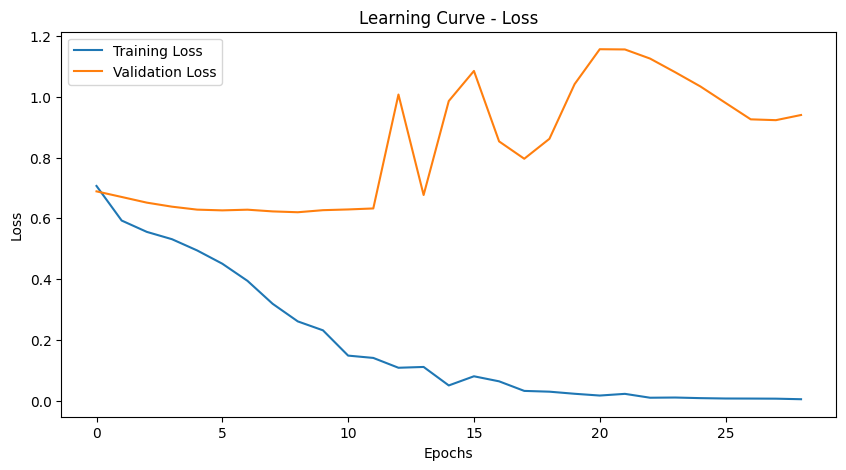

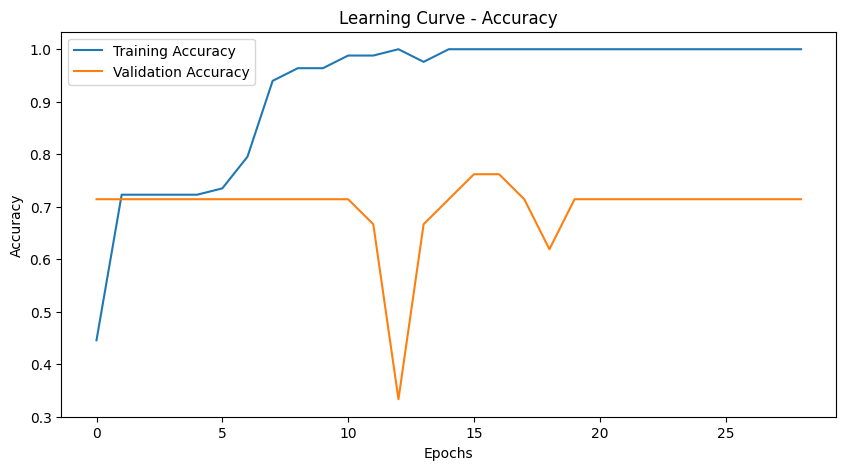

In [ ]:
import matplotlib.pyplot as plt

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss")
plt.legend()
plt.show()

# Plot Accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Accuracy")
plt.legend()
plt.show()


In [ ]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

<ipython-input-44-a95518f0c72b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


MFFNet(
  (text_model): MSFastformer(
    (layernorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (conv1): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv5): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
    (fastformer): FastformerLayer(
      (attention): FastAttention(
        (self): FastSelfAttention(
          (query): Linear(in_features=1024, out_features=1024, bias=True)
          (query_att): Linear(in_features=1024, out_features=16, bias=True)
          (key): Linear(in_features=1024, out_features=1024, bias=True)
          (key_att): Linear(in_features=1024, out_features=16, bias=True)
          (transform): Linear(in_features=1024, out_features=1024, bias=True)
          (softmax): Softmax(dim=-1)
        )
        (output): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (intermediate): Linear(in_features=1024, out_features=3072, b

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for text_batch, audio_batch, text_mask, audio_mask, label_batch in test_loader:
        # Move to GPU/CPU device
        text_batch = text_batch.to(device)
        audio_batch = audio_batch.to(device)
        text_mask = text_mask.to(device)
        audio_mask = audio_mask.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        logits = model(text_batch, audio_batch, text_mask, audio_mask)

        # Predicted labels
        _, predicted = torch.max(logits, dim=1)

        # Collect predictions and labels on CPU
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


              precision    recall  f1-score   support

     Class 0       0.71      1.00      0.83        15
     Class 1       0.00      0.00      0.00         6

    accuracy                           0.71        21
   macro avg       0.36      0.50      0.42        21
weighted avg       0.51      0.71      0.60        21



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
